In [7]:
import pprint
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
import spotipy
import spotipy.util as util

## SETUP
# C:\MongoDB\bin\mongod.exe --dbpath=C:\MongoDB\data\db --directoryperdb
pp = pprint.PrettyPrinter()
client = MongoClient('localhost', 27017)
db = client.server

In [38]:
## Authentication
username = 'Ariel Godinho'
scope = 'user-top-read user-library-read playlist-modify-private playlist-read-private user-read-playback-state user-modify-playback-state'
token = util.prompt_for_user_token(
    username,
    scope,
    client_id='9c93bd032a4340b086b31bd30ec8f24c',
    client_secret='b893fd0a51d34e2399effa91c1026de7',
    redirect_uri='http://localhost:8888/tree')

if token:
    #Set token to spotify library
    sp = spotipy.Spotify(auth=token)
    print("Token get successful. token", token)
else:
    print("Can't get token for", username)

Token get successful. token BQBECNuajWpCJr0SeDc8JISTK221eigBldkyEp_BcCX0L1gus4qFIMLLp7Ghn1u8RTmYz-YqQ00yv4o0nkHbJxEsPd36MSd0CI7ukAHG-mPPECrT_EJDAwZDhb01_6vDU35MjSW1Y531YRMoHFRGMrmFBfU73MDE9eVGqJDkDODpQ5L1Tx6H4ZWKglgwCE7Nas9Zdx8d0_r37rOln9zn


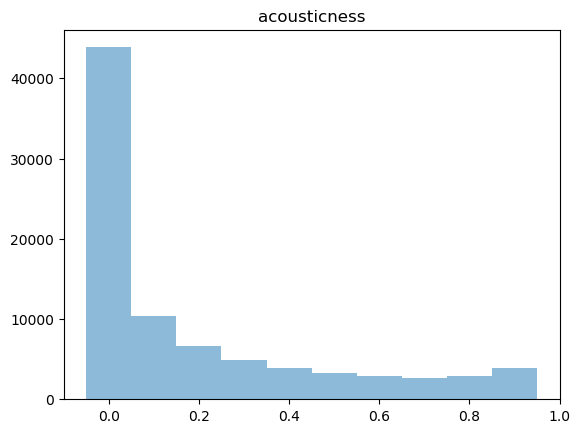

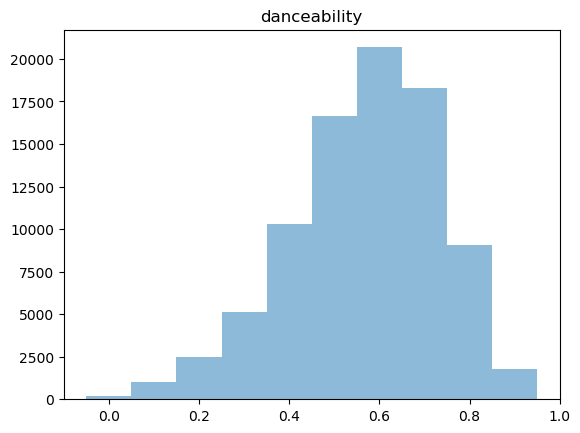

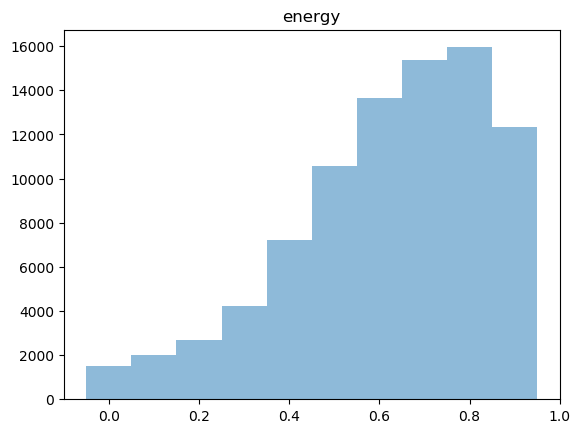

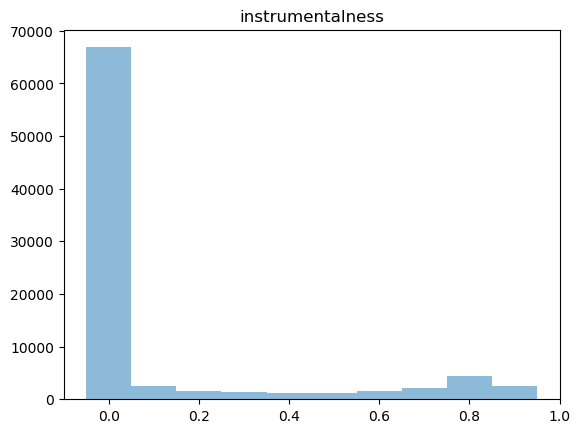

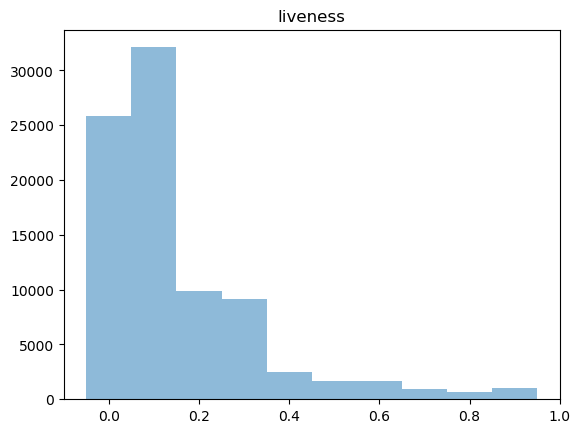

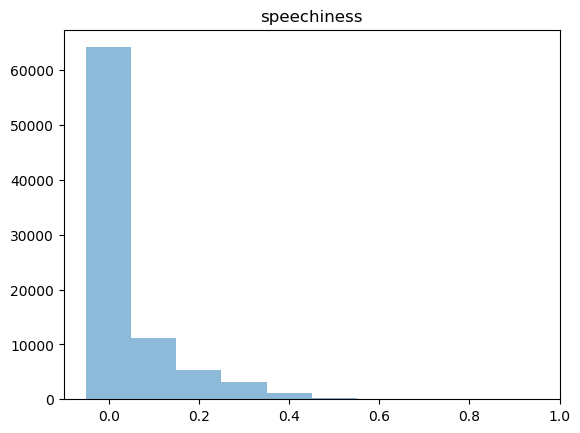

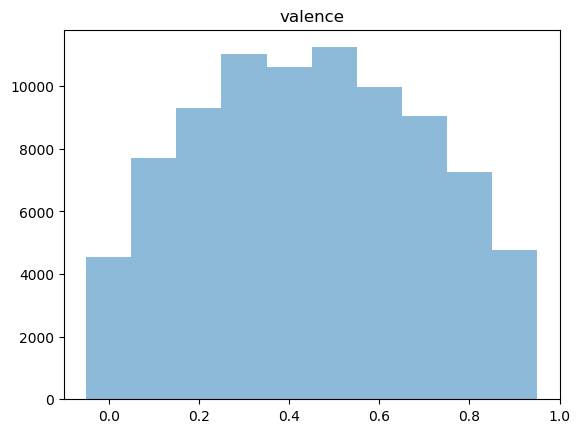

In [156]:
#Plot features distribution
interval_count = 10
intervals = np.arange(0, 1, 1/interval_count)
count_array = [
    ('acousticness', np.zeros(interval_count)),
    ('danceability', np.zeros(interval_count)),
    ('energy', np.zeros(interval_count)),
    ('instrumentalness', np.zeros(interval_count)),
    ('liveness', np.zeros(interval_count)),
    ('speechiness', np.zeros(interval_count)),
    ('valence', np.zeros(interval_count)),
]

values_array=[]
for track in db.tracks.find():
    item = track['features']
    values_array.append([
        item['acousticness'],
        item['danceability'],
        item['energy'],
        item['instrumentalness'],
        item['liveness'],
        item['speechiness'],
        item['valence'],
    ])
    for feature in count_array:
        value = item[feature[0]]
        norm_value =  int((value * interval_count) // 1)
        if(norm_value == interval_count):
            norm_value-=1
        feature[1][norm_value] += 1

for array in count_array:
    plt.bar(intervals, array[1], width=1/interval_count, align='center', alpha=0.5)
    plt.title(array[0])
    plt.show()

In [8]:
def elbow_k_means(values, min_k, max_k):
    total_distances = []
    
    for n in range(min_k, max_k):
        (centroids, labels, total_distance) = k_means(values, n)
        total_distances.append(total_distance)
        print('total_distance =', total_distance)
        
    plot_elbow_k_means(total_distances, min_k, max_k)

In [9]:
def plot_elbow_k_means(total_distances, min_k, max_k):
    k_list = list(range(min_k, max_k))
    plt.plot(k_list, total_distances)
    plt.show()

In [103]:
def euclidian_distance(pointA, pointB):
    distance = 0
    for valA, valB in zip(pointA, pointB):
        distance += (valA - valB) ** 2
    
    return math.sqrt(distance)

In [11]:
def sum_distances(centroids, labels, values):
    total_sum = 0
    
    for value, label in zip(values, labels):
        total_sum += euclidian_distance(value, centroids[label]) ** 2        
        
    return total_sum

In [12]:
def extract_features_from_tracks(tracks):
    features = []
    for track in tracks:
        item = track['features']
        features.append([
            item['acousticness'],
            item['danceability'],
            item['energy'],
            item['instrumentalness'],
            item['liveness'],
            item['speechiness'],
            item['valence'],
        ])
    return features

In [13]:
def k_means(values, k):
    clf = KMeans(n_clusters = k)
    clf.fit(values)

    print('Fit done. k =', k)

    centroids = clf.cluster_centers_
    labels = clf.labels_

    total_distance = sum_distances(centroids, labels, values)
    
    return (centroids, labels, total_distance)

In [32]:
def generate_playlist(centroid, user_id='12152580425', playlist_id='0exKLbWsQeivgmAxRud8XS'):
    distance_list = []
    for track in db.tracks.find({'popularity' : {"$gte": min_popularity}}):
        item = track['features']
        feature = [
            item['acousticness'],
            item['danceability'],
            item['energy'],
            item['instrumentalness'],
            item['liveness'],
            item['speechiness'],
            item['valence'],
        ]
        distance = euclidian_distance(centroid, feature)
        distance_list.append((distance, track['popularity'], track['id'], track['name']))

    distance_list.sort()
    for j in range(10):
        print(j, '-', distance_list[j][0] // 0.001 / 1000, '-', distance_list[j][3])

    # Playlist Creation!
    sp.user_playlist_replace_tracks(user=user_id, playlist_id=playlist_id, tracks=[item[2] for item in distance_list[0:10]])
    context_uri='spotify:user:'+user_id+':playlist:'+playlist_id
    sp.start_playback(context_uri=context_uri)

In [73]:
def standart_deviation(mean, values):
    sd_vector = []
    for i in range(len(mean)):
        d_sum = 0
        for value in values:
            d_sum += (mean[i] - value[i]) ** 2
        sd = math.sqrt(d_sum / (len(values)-1))
        sd_vector.append(sd)
    return sd_vector

Fit done. k = 10
total_distance = 1733.2714942804882
Fit done. k = 11
total_distance = 1672.8209526196315
Fit done. k = 12
total_distance = 1619.459719590948
Fit done. k = 13
total_distance = 1566.1854373913884
Fit done. k = 14
total_distance = 1517.322416556644
Fit done. k = 15
total_distance = 1475.1119094883047
Fit done. k = 16
total_distance = 1432.9983543239546
Fit done. k = 17
total_distance = 1400.6118435592118
Fit done. k = 18
total_distance = 1368.029367019668
Fit done. k = 19
total_distance = 1334.1857621509364


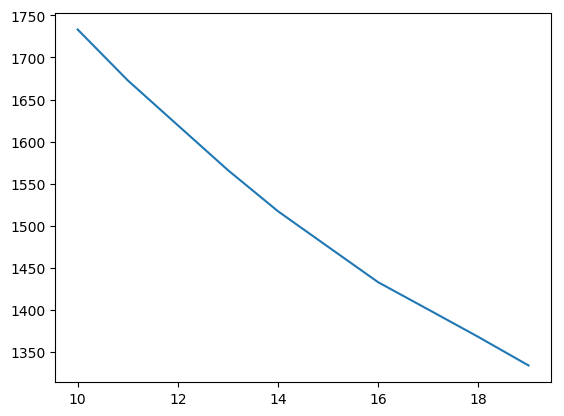

In [46]:
min_popularity = 50
elbow_k_means(extract_features_from_tracks(list(db.tracks.find({'popularity' : {'$gte' : min_popularity}}))), 10, 20)

Fit done. k = 2
total_distance = 268.5026426143948
Fit done. k = 3
total_distance = 224.39895393808794
Fit done. k = 4
total_distance = 187.35935608972494
Fit done. k = 5
total_distance = 156.9985537378884
Fit done. k = 6
total_distance = 145.7067797284475
Fit done. k = 7
total_distance = 136.89813823037312
Fit done. k = 8
total_distance = 128.88402710303995
Fit done. k = 9
total_distance = 122.39735391775216
Fit done. k = 10
total_distance = 116.7318439551647
Fit done. k = 11
total_distance = 110.84575286663669
Fit done. k = 12
total_distance = 106.66810249096277
Fit done. k = 13
total_distance = 102.52531071193866
Fit done. k = 14
total_distance = 98.87867932870417
Fit done. k = 15
total_distance = 96.47760245857435
Fit done. k = 16
total_distance = 93.17583835489104
Fit done. k = 17
total_distance = 90.7020842753803
Fit done. k = 18
total_distance = 87.86495848088967
Fit done. k = 19
total_distance = 86.35587079867189
Fit done. k = 20
total_distance = 85.03533110260203
Fit done. k =

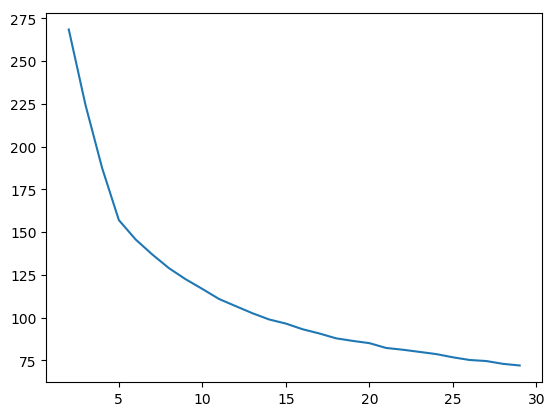

In [45]:
# User's tracks clustering
elbow_k_means(extract_features_from_tracks(user_tracks), 2, 30)

In [157]:
# plot scatter Kmeans
min_popularity = 50
values = extract_features_from_tracks(list(db.tracks.find({'popularity' : {'$gte' : min_popularity}})))
(centroids, labels, total_distance) = k_means(extract_features_from_tracks(user_tracks), 10)
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.']

for i in range(len(values)):
    plt.plot(values[i][0], values[i][1], colors[labels[i]], markersize = 1)
    print(i, end='\r')
    
plt.scatter(centroids[:,0], centroids[:,1], marker = 'x', s=150, linewidths=5)
plt.show()

IndexError: index 1473 is out of bounds for axis 0 with size 1473

In [15]:
# Get user tracks
track_ids = db.users.find_one({'id' : '12152580425'})['tracks_ids']
results = db.tracks.find({'id' : {'$in' : track_ids}})
user_tracks = []
for item in results:
    user_tracks.append(item)

Fit done. k = 8
Centroid 0 - count =  287
0 - 0.057 - Better With The Lights Off (feat. Chris Brown)
1 - 0.059 - Take My Hand
2 - 0.059 - Rhythm Is A Dancer (feat. Kaleena Zanders)
3 - 0.062 - The Last Of The Real Ones
4 - 0.069 - Real Love
5 - 0.07 - Want You Back
6 - 0.071 - We Are Tonight
7 - 0.071 - Heaven Knows
8 - 0.072 - Without You
9 - 0.072 - Til I Forget About You


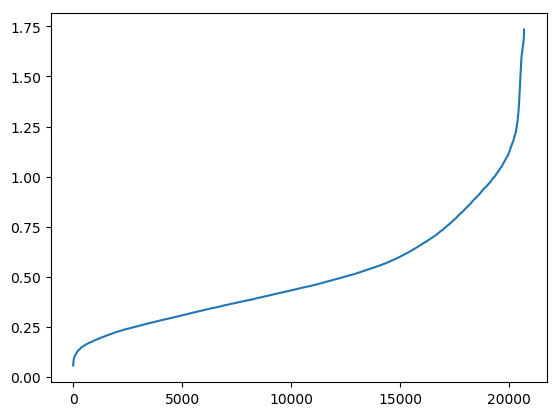

Centroid 1 - count =  75
0 - 0.104 - Bless The Broken Road
1 - 0.116 - Reminiscing - Remastered
2 - 0.118 - The Few Things (with Charlotte Lawrence)
3 - 0.119 - Walls - Naked Edition
4 - 0.129 - Grace
5 - 0.131 - Where I Stood
6 - 0.138 - Spirit Cold
7 - 0.139 - The Rest of Our Life
8 - 0.142 - Solução
9 - 0.143 - The Stable Song


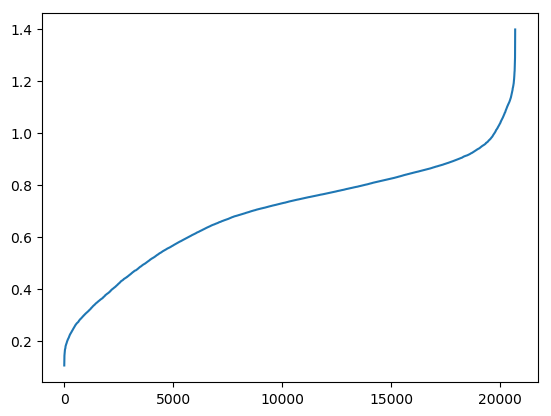

Centroid 2 - count =  205
0 - 0.057 - Hold On, We're Going Home
1 - 0.059 - Blame It
2 - 0.061 - Truth Hurts
3 - 0.066 - DaNcing in a RoOm
4 - 0.071 - Love a Loser (feat. G-Eazy)
5 - 0.072 - Hurts So Good
6 - 0.073 - Rewind
7 - 0.073 - No Other
8 - 0.078 - Tusen Bitar
9 - 0.081 - Tripping Off


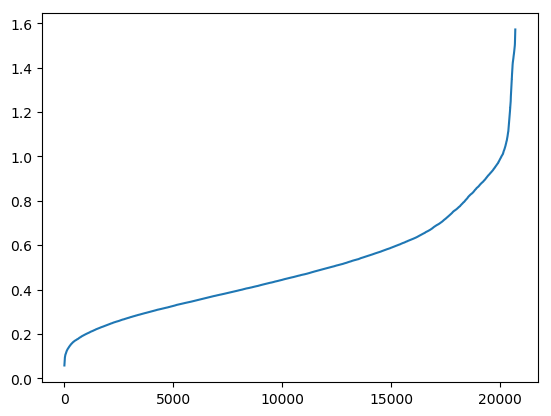

Centroid 3 - count =  121
0 - 0.101 - Machine
1 - 0.102 - About A Girl
2 - 0.108 - Pierre
3 - 0.14 - Faz Parte - Ao Vivo
4 - 0.157 - Chora, Me Liga - Ao Vivo
5 - 0.159 - Já Sei Namorar - VIP Studio Session
6 - 0.168 - Ar-Condicionado No 15 - Ao Vivo
7 - 0.169 - Suíte 14 - Ao Vivo
8 - 0.17 - Pra Quando Você Se Lembrar de Mim - Acústico
9 - 0.17 - Prohibido Quererme - En Vivo


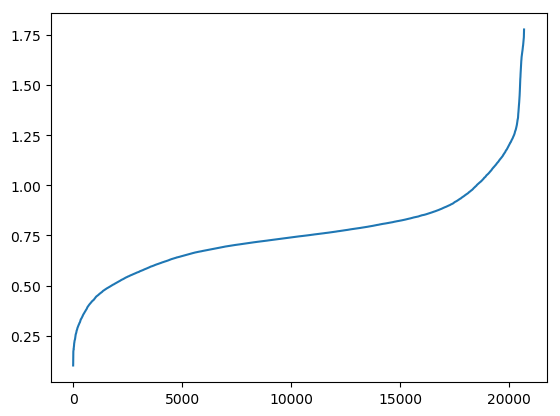

Centroid 4 - count =  246
0 - 0.057 - Fearless
1 - 0.067 - All Goes Wrong
2 - 0.069 - Ghost
3 - 0.076 - Ocean
4 - 0.079 - Dog Days Are Over
5 - 0.08 - Lips Of An Angel
6 - 0.08 - Disarm You (feat. Ilsey)
7 - 0.081 - Survivors
8 - 0.081 - My Moment (feat. 2 Chainz, Meek Mill and Jeremih)
9 - 0.084 - Shed a Tear


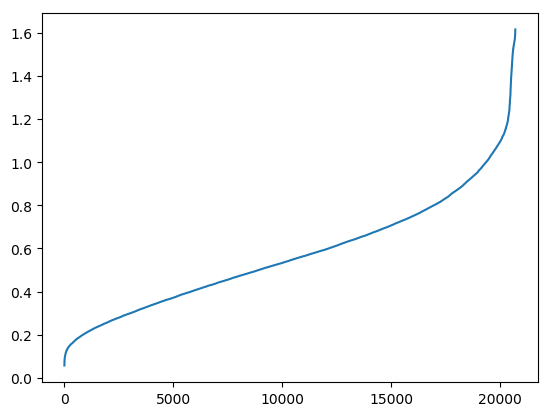

Centroid 5 - count =  330
0 - 0.044 - Nossa Música
1 - 0.049 - 20 Min
2 - 0.055 - No Way No
3 - 0.061 - Borro Cassette
4 - 0.07 - Lil Craney
5 - 0.076 - Rave in the Grave
6 - 0.077 - Picky
7 - 0.08 - S.L.U.T.
8 - 0.08 - Leave Me Alone
9 - 0.081 - Lay Me Down


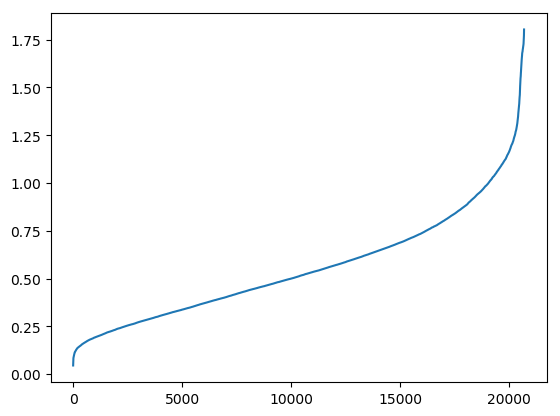

Centroid 6 - count =  85
0 - 0.144 - Apollo
1 - 0.147 - Hinode
2 - 0.159 - You Know - Radio Edit
3 - 0.166 - U Got 2 Let The Music
4 - 0.168 - Beautiful Girl
5 - 0.168 - King Kong (HI-LO Touch)
6 - 0.174 - Strobe - Lane 8 Remix
7 - 0.176 - Takeoff
8 - 0.181 - Inhaler
9 - 0.183 - '75 aka Stay With You


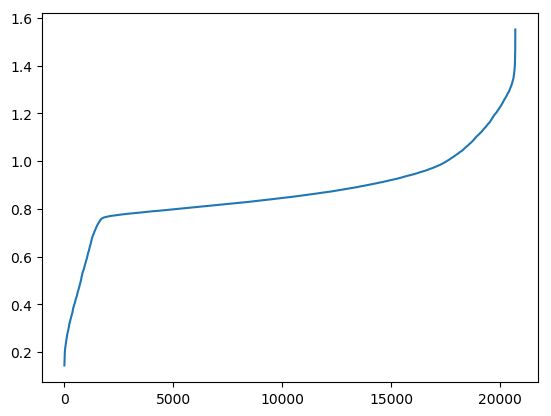

Centroid 7 - count =  124
0 - 0.076 - Time Is Now
1 - 0.091 - Se Eu Tiver Solteiro
2 - 0.091 - Addicted To You
3 - 0.096 - Rockabye (feat. Sean Paul & Anne-Marie)
4 - 0.099 - Rollin
5 - 0.101 - Bandolera
6 - 0.103 - Up In Hudson
7 - 0.103 - The Logical Song - Remastered 2010
8 - 0.108 - Fifa
9 - 0.11 - I Miss You (feat. Bahari)


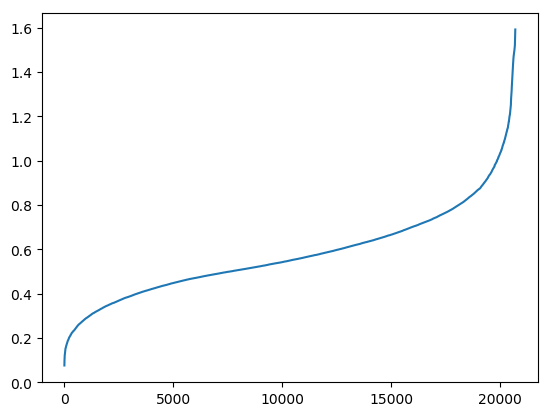

In [108]:
min_popularity = 50
values = extract_features_from_tracks(user_tracks)
deviations = []
(centroids, labels, total_distance) = k_means(values, 8)
for i in range(len(centroids)):
    centroid = centroids[i]
    
    print('Centroid', i, '- count = ', list(labels).count(i))
    sd = standart_deviation(centroid, [item[0] for item in zip(values, labels) if item[1] == i])
    deviations.append(sd)
    
    distance_list = []
    for track in db.tracks.find({'popularity' : {"$gte": min_popularity}}):
        item = track['features']
        feature = [
            item['acousticness'],
            item['danceability'],
            item['energy'],
            item['instrumentalness'],
            item['liveness'],
            item['speechiness'],
            item['valence'],
        ]
        distance = euclidian_distance(centroid, feature)
        distance_list.append((distance, track['popularity'], track['id'], track['name']))

    distance_list.sort()
    for j in range(10):
        print(j, '-', distance_list[j][0] // 0.001 / 1000, '-', distance_list[j][3])  
    plt.plot(list(range(len(distance_list))), [distance[0] for distance in distance_list])
    plt.show()

In [92]:
columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
df = pd.DataFrame(centroids, columns=columns)
df = df.round(decimals=2)
df['count'] = [list(labels).count(i)for i in range(len(centroids))]
display(df)
df2 = pd.DataFrame([[str(round(c,2)) + ' $\pm$ ' + str(round(v,2)) for (c, v) in zip(cen, dev)] for (cen, dev) in zip(centroids, deviations)], columns=columns)
df2['count'] = [list(labels).count(i)for i in range(len(centroids))]
display(df2)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,count
0,0.09,0.76,0.70,0.01,0.15,0.11,0.79,280
1,0.05,0.60,0.84,0.01,0.21,0.08,0.62,286
2,0.65,0.55,0.46,0.07,0.20,0.07,0.39,81
3,0.09,0.66,0.75,0.75,0.21,0.06,0.40,87
4,0.11,0.68,0.61,0.02,0.15,0.08,0.37,226
5,0.21,0.59,0.81,0.02,0.76,0.09,0.59,120
6,0.04,0.47,0.83,0.02,0.18,0.08,0.29,268
7,0.46,0.69,0.75,0.01,0.17,0.11,0.73,125


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,count
0,0.09 $\pm$ 0.08,0.76 $\pm$ 0.09,0.7 $\pm$ 0.13,0.01 $\pm$ 0.06,0.15 $\pm$ 0.1,0.11 $\pm$ 0.1,0.79 $\pm$ 0.11,280
1,0.05 $\pm$ 0.06,0.6 $\pm$ 0.1,0.84 $\pm$ 0.08,0.01 $\pm$ 0.03,0.21 $\pm$ 0.12,0.08 $\pm$ 0.06,0.62 $\pm$ 0.11,286
2,0.65 $\pm$ 0.17,0.55 $\pm$ 0.18,0.46 $\pm$ 0.16,0.07 $\pm$ 0.23,0.2 $\pm$ 0.17,0.07 $\pm$ 0.07,0.39 $\pm$ 0.17,81
3,0.09 $\pm$ 0.16,0.66 $\pm$ 0.14,0.75 $\pm$ 0.16,0.75 $\pm$ 0.15,0.21 $\pm$ 0.2,0.06 $\pm$ 0.04,0.4 $\pm$ 0.25,87
4,0.11 $\pm$ 0.1,0.68 $\pm$ 0.1,0.61 $\pm$ 0.12,0.02 $\pm$ 0.06,0.15 $\pm$ 0.1,0.08 $\pm$ 0.09,0.37 $\pm$ 0.13,226
5,0.21 $\pm$ 0.22,0.59 $\pm$ 0.12,0.81 $\pm$ 0.13,0.02 $\pm$ 0.07,0.76 $\pm$ 0.14,0.09 $\pm$ 0.08,0.59 $\pm$ 0.2,120
6,0.04 $\pm$ 0.07,0.47 $\pm$ 0.12,0.83 $\pm$ 0.1,0.02 $\pm$ 0.06,0.18 $\pm$ 0.11,0.08 $\pm$ 0.08,0.29 $\pm$ 0.11,268
7,0.46 $\pm$ 0.13,0.69 $\pm$ 0.11,0.75 $\pm$ 0.12,0.01 $\pm$ 0.06,0.17 $\pm$ 0.11,0.11 $\pm$ 0.09,0.73 $\pm$ 0.14,125


In [54]:
generate_playlist(centroids[13])

0 - 0.075 - Lost In My Boots
1 - 0.094 - Girls Like You
2 - 0.095 - Cataflor
3 - 0.097 - Between the Devil and the Deep Blue Sea
4 - 0.098 - One For Daddy-O - Remastered
5 - 0.107 - The Few Things (with Charlotte Lawrence)
6 - 0.108 - Reminiscing - Remastered
7 - 0.109 - Bless The Broken Road
8 - 0.109 - All We Are
9 - 0.113 - The Rest of Our Life


In [141]:
# Returns a value from 0 to 1 indicating the fit of the track in relation to the user
def recommendation_performance(user_tracks, track, centroids, labels, deviations, distance_list):
    performance = 0
    centroid = centroids[0]
    n_features = len(centroid)
    
    #find closest centroid and biggest centroid size
    lesser_distance = 999
    greatest_count = 0
    cluster_index = 0
    for i in range(len(centroids)):
        c = centroids[i]
        distance = euclidian_distance(c, extract_features_from_tracks(tracks=[track])[0])
        count = list(labels).count(i)
        if distance < lesser_distance:
            lesser_distance = distance
            centroid = c
            cluster_index = i
        if count > greatest_count:
            greatest_count = count
    
    #ratio of the cluster's respective size in relation to the biggest cluster
    cluster_size_ratio = list(labels).count(cluster_index) / greatest_count
    
    # Avarage of the cluster's deviations
    cluster_avg_deviation = 0
    for val in deviations[cluster_index]:
        cluster_avg_deviation += val **2        
    cluster_avg_deviation = math.sqrt(cluster_avg_deviation) / n_features
    
    return (cluster_index, cluster_size_ratio, cluster_avg_deviation, lesser_distance)

In [142]:
performance_list = []
for track in user_tracks:
    performance = recommendation_performance(user_tracks, track, centroids, labels, deviations, distance_list)
    performance_list.append(performance)
df = pd.DataFrame(performance_list)
df

,0,1,2,3
0,0,0.869697,0.032084,0.245569
1,4,0.745455,0.037429,0.382120
2,0,0.869697,0.032084,0.240532
3,4,0.745455,0.037429,0.216544
4,4,0.745455,0.037429,0.229700
5,0,0.869697,0.032084,0.245558
6,5,1.000000,0.036556,0.225717
7,4,0.745455,0.037429,0.132016
8,5,1.000000,0.036556,0.254476
9,4,0.745455,0.037429,0.268973


In [143]:
df.mean()

0    3.299389
1    0.692623
2    0.041168
3    0.270713
dtype: float64

In [144]:
df.max()

0    7.000000
1    1.000000
2    0.064307
3    1.092414
dtype: float64